### 📦 Importing Dataset: Stable-ImageNet1K

We will be using the **Stable-ImageNet1K** dataset, which contains:

- **100 images** from each of **1,000 different classes**
- A total of **100,000 images**
- Approximately **10.5 GB** in size

> ⏳ Note: Downloading this dataset may take a while due to its size — but once it's cached, future accesses will be much faster.


In [1]:
import kagglehub

path = kagglehub.dataset_download("vitaliykinakh/stable-imagenet1k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stable-imagenet1k


### 🛠️ Importing Necessary Libraries

Before we begin, let's import the essential libraries required for loading the dataset, preprocessing, and model training.


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2025-05-04 18:33:05.731261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746383586.216822      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746383586.348749      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 🗂️ Loading Image Paths

We will now load all image file paths from the dataset directory.  
Only files with the `.jpg` extension will be considered, ensuring we include only valid image files.


In [3]:
image_paths = glob.glob('/kaggle/input/stable-imagenet1k/imagenet1k/*/*.jpg') 
print(f"Total images: {len(image_paths)}")

image_paths = tf.constant(image_paths)

Total images: 100001


I0000 00:00:1746383618.331335      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746383618.332044      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### 🧹 Preprocessing

Since we are using an **autoencoder architecture**, our goal is to reconstruct the original color image from a simplified input.  
To achieve this, we:

- Convert the **ground truth color images** into a set of **grayscale images** to serve as the input to the autoencoder.
- This allows the model to **learn the mapping from grayscale to color**, effectively performing image colorization.

> 📌 This setup is ideal for learning meaningful representations, especially in tasks like unsupervised feature learning or image-to-image translation.


In [4]:
IMG_SIZE = 128

def decode_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    gray = tf.image.rgb_to_grayscale(img)
    return gray, img

In [5]:
# Ensure image_paths is a plain list
image_paths = image_paths.numpy().tolist() if hasattr(image_paths, 'numpy') else list(image_paths)

# Now split
train_paths, val_paths = train_test_split(image_paths, test_size=0.1, random_state=42)

### 🧪 Constructing Training and Validation Sets

We split our dataset into:

- A **training set** for learning the autoencoder weights.
- A **validation set** to monitor performance and prevent overfitting during training.

We do **not use a separate test set**, as this is an **unsupervised learning task**.  
Since we are not evaluating against labeled targets, our focus is on how well the model reconstructs input images.

> ⚠️ A test set could still be used for qualitative evaluation or metric-based comparison (e.g., PSNR or SSIM), but it is not strictly necessary in this context.


In [6]:
BATCH_SIZE = 64

IMG_SIZE = 128

def decode_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    gray = tf.image.rgb_to_grayscale(img)
    return gray, img

train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.shuffle(10000).map(decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)
val_dataset = val_dataset.map(decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### 📈 Defining PSNR and SSIM

To evaluate the performance of our autoencoder in reconstructing images, we use two widely adopted image quality metrics:

---

#### 🧮 Peak Signal-to-Noise Ratio (PSNR)

**PSNR** measures the ratio between the maximum possible power of a signal (image) and the power of corrupting noise (error introduced by reconstruction).  
It is expressed in decibels (dB), where a **higher PSNR indicates better reconstruction quality**.

**Formula:**

$$
\text{PSNR} = 10 \cdot \log_{10} \left( \frac{\text{MAX}^2}{\text{MSE}} \right)
$$

- **MAX** is the maximum possible pixel value of the image (e.g., 255 for 8-bit images)
- **MSE** is the Mean Squared Error between the original and reconstructed image:

$$
\text{MSE} = \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} \left[ I(i,j) - K(i,j) \right]^2
$$

where:

$$
\begin{aligned}
I(i, j) &\text{ is the pixel value of the original image} \\
K(i, j) &\text{ is the pixel value of the reconstructed image}
\end{aligned}
$$
---

#### 🧠 Structural Similarity Index Measure (SSIM)

**SSIM** evaluates image similarity based on perceptual factors like luminance, contrast, and structure.  
Unlike PSNR, which is purely pixel-based, **SSIM better aligns with human visual perception**.

**Formula:**

$$
\text{SSIM}(x, y) = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

Where:

$$
\begin{aligned}
\mu_x,\ \mu_y &\text{ are the means of images } x \text{ and } y \\
\sigma_x^2,\ \sigma_y^2 &\text{ are the variances of images } x \text{ and } y \\
\sigma_{xy} &\text{ is the covariance between } x \text{ and } y \\
C_1,\ C_2 &\text{ are constants to stabilize the division}
\end{aligned}
$$

$$
C_1 = (K_1 L)^2, \quad C_2 = (K_2 L)^2
$$

with \( L \) being the dynamic range of pixel values (e.g., 255), and \( K_1 = 0.01, K_2 = 0.03 \)

**Range:** SSIM values range from **-1 to 1**, where:  
- **1** indicates perfect structural similarity  
- **0 or less** implies no similarity

---

> ✅ **In summary**:  
> - **PSNR** gives a straightforward signal fidelity measure (good for optimization).  
> - **SSIM** offers a more perceptual quality assessment (good for image similarity).


In [7]:
@tf.keras.utils.register_keras_serializable()
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
    
@tf.keras.utils.register_keras_serializable()    
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

### 🧠 Autoencoder Architecture Overview

The `build_autoencoder` function defines a **convolutional autoencoder** that learns to map grayscale images to RGB color images. The architecture consists of three main parts:

---

#### 🔸 Encoder

The encoder progressively downsamples the input using convolutional layers with **LeakyReLU activations**, **batch normalization**, and **max pooling**:

- Input shape: \( (128, 128, 1) \) — a grayscale image
- Three encoding blocks:
  - Conv2D → BatchNorm → LeakyReLU → MaxPooling
  - Feature depth increases from 64 → 128 → 256

---

#### 🔹 Bottleneck

A deeper convolutional layer acts as the **bottleneck**, where the image is represented in a compressed feature space:

- Conv2D → BatchNorm → LeakyReLU
- Output depth: 512 filters
- No pooling here — acts as the "compressed latent representation"

---

#### 🔸 Decoder

The decoder upsamples the compressed features to reconstruct the full-resolution output:

- Three decoding blocks:
  - UpSampling → Concatenate (skip connection) → Conv2D → BatchNorm → LeakyReLU
  - Skip connections from encoder layers preserve spatial detail
  - Feature depth decreases from 256 → 128 → 64

---

#### 🎯 Output Layer

- Final `Conv2D` layer with **3 output channels** (RGB)
- Uses `sigmoid` activation to produce pixel values in the \([0, 1]\) range

---

> ✅ This architecture is well-suited for **image colorization**, as it learns to reconstruct full-color images from grayscale inputs using both global and local features.


In [8]:
def build_autoencoder(img_size=128):
    input_img = Input(shape=(img_size, img_size, 1))

    # Encoder
    x1 = Conv2D(64, (3,3), padding='same')(input_img)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU()(x1)
    p1 = MaxPooling2D((2,2))(x1)

    x2 = Conv2D(128, (3,3), padding='same')(p1)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU()(x2)
    p2 = MaxPooling2D((2,2))(x2)

    x3 = Conv2D(256, (3,3), padding='same')(p2)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU()(x3)
    p3 = MaxPooling2D((2,2))(x3)

    # 🔹 Bottleneck
    bn = Conv2D(512, (3,3), padding='same')(p3)
    bn = BatchNormalization()(bn)
    bn = LeakyReLU()(bn)

    # Decoder
    u3 = UpSampling2D((2,2))(bn)
    u3 = Concatenate()([u3, x3])
    x4 = Conv2D(256, (3,3), padding='same')(u3)
    x4 = BatchNormalization()(x4)
    x4 = LeakyReLU()(x4)

    u2 = UpSampling2D((2,2))(x4)
    u2 = Concatenate()([u2, x2])
    x5 = Conv2D(128, (3,3), padding='same')(u2)
    x5 = BatchNormalization()(x5)
    x5 = LeakyReLU()(x5)

    u1 = UpSampling2D((2,2))(x5)
    u1 = Concatenate()([u1, x1])
    x6 = Conv2D(64, (3,3), padding='same')(u1)
    x6 = BatchNormalization()(x6)
    x6 = LeakyReLU()(x6)

    # Output layer (RGB)
    output = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x6)

    model = Model(inputs=input_img, outputs=output)
    return model

In [9]:
strategy = tf.distribute.MirroredStrategy() #This is used because we ran on Kaggle with 2 GPUs
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=3,              
    restore_best_weights=True 
)

In [11]:
with strategy.scope():
    autoencoder = build_autoencoder()
    autoencoder.compile(optimizer='adam', loss='mse', metrics=[psnr, ssim])
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ leaky_re_lu[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ leaky_re_lu_2[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 512)    │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 3,880,067 (14.80 MB)

 Trainable params: 3,877,251 (14.79 MB)

 Non-trainable params: 2,816 (11.00 KB)

### Training the Autoencoder

In [12]:
history = autoencoder.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20


I0000 00:00:1746383633.411695     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746383633.412388     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 548s 376ms/step - loss: 0.0113 - psnr: 21.2693 - ssim: 0.8851 - val_loss: 0.0097 - val_psnr: 22.0021 - val_ssim: 0.9080
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 533s 379ms/step - loss: 0.0095 - psnr: 21.9311 - ssim: 0.9090 - val_loss: 0.0097 - val_psnr: 21.6197 - val_ssim: 0.9088
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 536s 380ms/step - loss: 0.0093 - psnr: 22.0592 - ssim: 0.9118 - val_loss: 0.0092 - val_psnr: 22.0786 - val_ssim: 0.9146
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 538s 382ms/step - loss: 0.0092 - psnr: 22.1155 - ssim: 0.9130 - val_loss: 0.0123 - val_psnr: 20.1694 - val_ssim: 0.9023
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 537s 381ms/step - loss: 0.0090 - psnr: 22.1981 - ssim: 0.9142 - val_loss: 0.0121 - val_psnr: 20.4712 - val_ssim: 0.8970
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 536s 380ms/step - loss: 0.0090 - psnr: 22.2613 - ssim: 0.9151 - val_loss: 0.0097 - val_psnr: 21.6056 - val_ssim: 0.9101


In [13]:
from joblib import dump

autoencoder.save('ColorNet.keras')
dump(autoencoder, 'ColorNet.pkl')

['ColorNet.pkl']

### Plotting Training and Validation performance

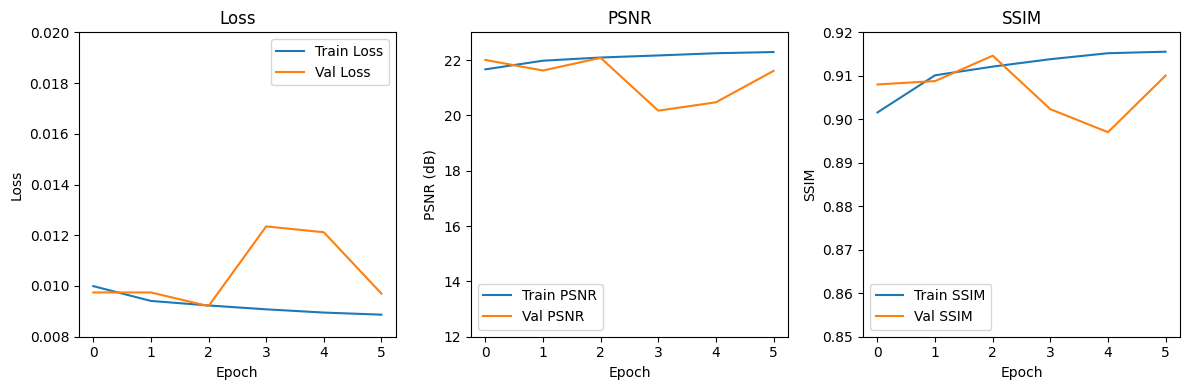

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.008, 0.02)  


if 'psnr' in history.history:
    plt.subplot(1, 3, 2)
    plt.plot(history.history['psnr'], label='Train PSNR')
    if 'val_psnr' in history.history:
        plt.plot(history.history['val_psnr'], label='Val PSNR')
    plt.title('PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.ylim(12, 23)
    
if 'ssim' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['ssim'], label='Train SSIM')
    if 'val_ssim' in history.history:
        plt.plot(history.history['val_ssim'], label='Val SSIM')
    plt.title('SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.ylim(0.85, 0.92)  

plt.tight_layout()
plt.show()

In [15]:
'''
test_batch = next(iter(dataset.take(1)))
grayscale_imgs, real_color_imgs = test_batch
'''

'\ntest_batch = next(iter(dataset.take(1)))\ngrayscale_imgs, real_color_imgs = test_batch\n'

In [16]:
test_batch = next(iter(val_dataset.take(2)))
grayscale_imgs, real_color_imgs = test_batch

In [17]:
predicted_color_imgs = autoencoder.predict(grayscale_imgs)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


### 🖼️ Visualizing Reconstruction Results

To qualitatively assess the performance of our autoencoder, we can visualize:

- The **input grayscale image**
- The **reconstructed color image**
- The **original ground truth color image**

This helps us see how well the model is learning to colorize grayscale inputs.


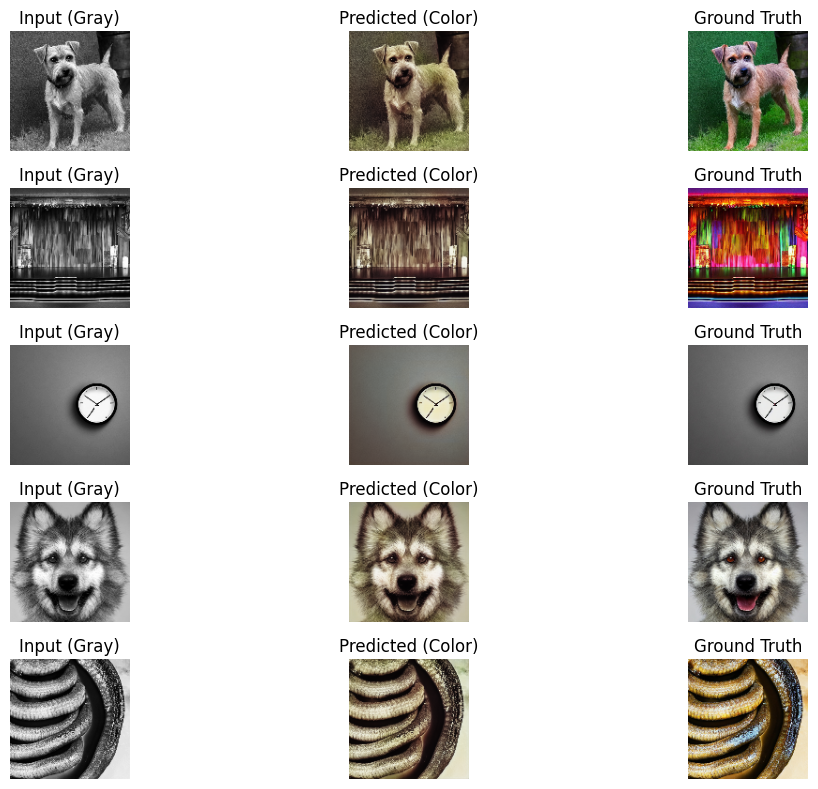

In [18]:
n = 5
plt.figure(figsize=(12, 8))

for i in range(n):
    # Grayscale input
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(tf.squeeze(grayscale_imgs[i+35]), cmap='gray')
    plt.title("Input (Gray)")
    plt.axis('off')
    
    # Colorized output
    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(predicted_color_imgs[i+35])
    plt.title("Predicted (Color)")
    plt.axis('off')
    
    # Ground truth color
    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(real_color_imgs[i+35])
    plt.title("Ground Truth")
    plt.axis('off')

plt.tight_layout()
plt.show()